In [1]:
%cd ..

/mnt/cup/labs/hasson/zaid/fmri-convs


In [2]:
# import sys
# from importlib import reload
# reload(sys.modules['constants'])
# resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1e9

In [3]:
from glob import glob

import pickle
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from himalaya.viz import plot_alphas_diagnostic
from nilearn.plotting import plot_glass_brain
from constants import CONVS_STRANGERS
from seaborn import color_palette

from neuromaps.datasets import fetch_fslr  # , fetch_fsaverage
from neuromaps.transforms import mni152_to_fslr  # , mni152_to_fsaverage
from surfplot import Plot
from surfplot.utils import threshold

import nibabel as nib
from util.atlas import get_schaefer
from typing import Optional
from nilearn.maskers import NiftiLabelsMasker

import pandas as pd
from util.path import Path

In [4]:
modelname = "glove-300"
modelname = "gpt2"

modelname = "model-gpt2-medium_layer-0.75"

In [5]:
pklpath = Path(
    root="encoding",
    # sub=f"{sub:03d}",
    datatype=modelname,
    ext=".pkl",
)

# with open(pklpath.fpath, 'rb') as f:
#     result = pickle.load(f)

In [6]:
files = glob(pklpath.starstr(["sub", "datatype"]))
len(files)

48

In [6]:
# Ensure we have all conversations
a, b = np.unique([f.split("/")[1][-2:] for f in files], return_counts=True)
print(list(zip(a, b)))
# missing conversations
set(CONVS_STRANGERS) - set([int(z) + 100 for z in a])

[('04', 2), ('05', 2), ('06', 2), ('07', 2), ('08', 2), ('11', 2), ('12', 2), ('14', 2), ('16', 2), ('17', 2), ('22', 2), ('23', 2), ('26', 2), ('28', 2), ('29', 2), ('31', 2), ('37', 2), ('42', 2), ('53', 2), ('56', 2), ('57', 2), ('58', 2), ('63', 2), ('74', 2)]


{120, 132, 133, 138, 143}

In [7]:
# Manually load files?
files = []
for conv in CONVS_STRANGERS:
    files.append(f"encoding/sub-{conv-100:03d}/{modelname}/sub-{conv-100:03d}.pkl")
    files.append(f"encoding/sub-{conv:03d}/{modelname}/sub-{conv:03d}.pkl")
len(files)

58

In [7]:
results = []
for filename in files:
    if os.path.isfile(filename):
        with open(filename, "rb") as f:
            results.append(pickle.load(f))

In [8]:
backend = np
backend = torch

scores = []
scores_prod = []
scores_comp = []
alphas = []
for result in results:
    scores.append(backend.stack(result["cv_scores"]).numpy(force=True))
    scores_prod.append(backend.stack(result["cv_scores_prod"]).numpy(force=True))
    scores_comp.append(backend.stack(result["cv_scores_comp"]).numpy(force=True))
    alphas.append(backend.stack(result["cv_alphas"]).numpy(force=True))

print(len(scores))
print(scores[0].shape)
all_scores = np.vstack(scores).mean(0)  # avg over subjects and folds
all_prods = np.vstack(scores_prod).mean(0)  # avg over subjects and folds
all_comps = np.vstack(scores_comp).mean(0)  # avg over subjects and folds
all_scores.shape

48
(5, 3, 1000)


(3, 1000)

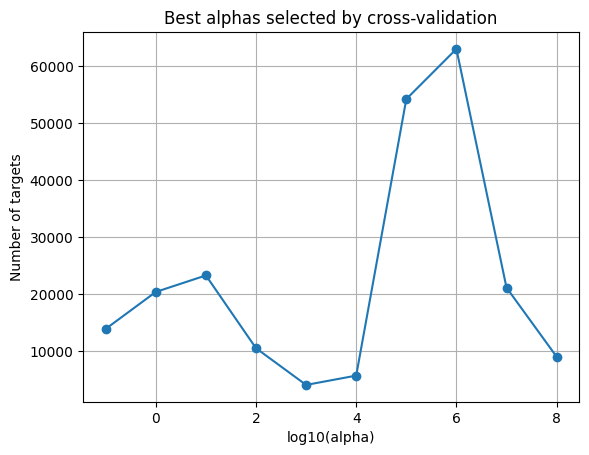

In [32]:
alpha_range = np.logspace(-1, 8, 10)
best_alphas = np.vstack(alphas).flatten()
plot_alphas_diagnostic(best_alphas, alpha_range)
plt.title("Best alphas selected by cross-validation")
plt.show()

In [9]:
# Set up masker
atlas, _ = get_schaefer(n_rois=1000)

masker = NiftiLabelsMasker(
    labels_img=atlas,
    strategy="mean",
    reports=False,
)

masker.fit(atlas)

NiftiLabelsMasker(labels_img='mats/Schaefer2018_1000Parcels_17Networks_order_FSLMNI152_3mm.nii.gz',
                  reports=False)

## ROIs

In [35]:
# Set up masker
roi_atlas = nib.load("mats/language_rois.nii.gz")
roi_labels = (
    pd.read_csv("mats/language_rois.csv", header=None, index_col=0)
    .values.flatten()
    .tolist()
)

roi_masker = NiftiLabelsMasker(
    labels_img=roi_atlas,
    strategy="mean",
    reports=False,
)

In [36]:
prod_roi_scores, comp_roi_scores = [], []

for i in range(len(scores)):
    # sub_scores = scores[i].mean(0)

    # sub_prod_scores = sub_scores[1]
    sub_prod_scores = scores_prod[i].mean(0)
    parc_prod_scores = masker.inverse_transform(sub_prod_scores)
    roi_prod_scores = roi_masker.fit_transform(parc_prod_scores)

    # sub_comp_scores = sub_scores[2]
    sub_comp_scores = scores_comp[i].mean(0)
    parc_comp_scores = masker.inverse_transform(sub_comp_scores)
    roi_comp_scores = roi_masker.fit_transform(parc_comp_scores)

    prod_roi_scores.append(roi_prod_scores)
    comp_roi_scores.append(roi_comp_scores)

prod_roi_scores = np.vstack(prod_roi_scores)
comp_roi_scores = np.vstack(comp_roi_scores)

KeyboardInterrupt: 

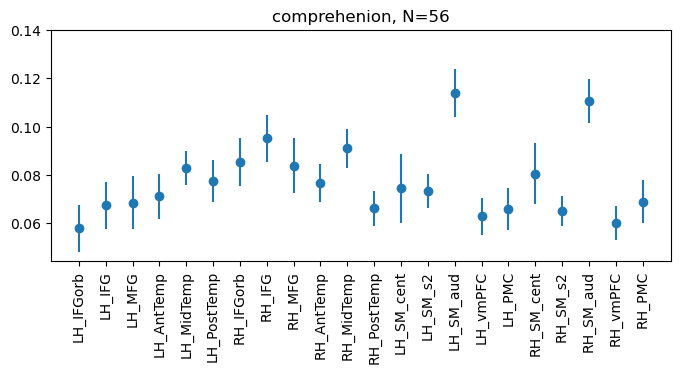

In [109]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.errorbar(
    range(22),
    comp_roi_scores.mean(0),
    yerr=comp_roi_scores.std(0) / np.sqrt(comp_roi_scores.shape[0]),
    fmt="o",
)
ax.set_ylim(ax.get_ylim()[0], 0.14)
ax.set_xticks(range(22))
ax.set_xticklabels(roi_labels, rotation=90)
ax.set_title(f"comprehenion, N={comp_roi_scores.shape[0]}")
plt.show()

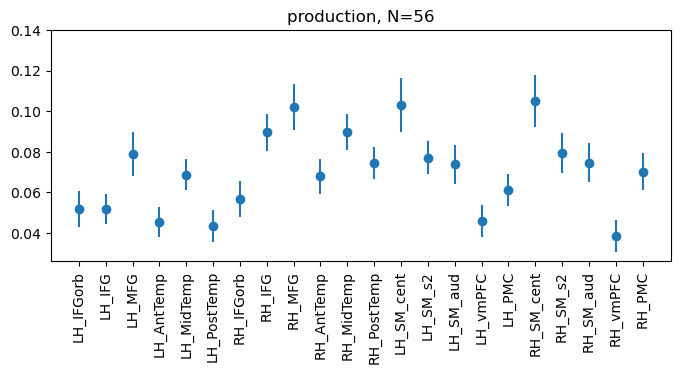

In [110]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.errorbar(
    range(22),
    prod_roi_scores.mean(0),
    yerr=prod_roi_scores.std(0) / np.sqrt(prod_roi_scores.shape[0]),
    fmt="o",
)
ax.set_ylim(ax.get_ylim()[0], 0.14)
ax.set_xticks(range(22))
ax.set_xticklabels(roi_labels, rotation=90)
ax.set_title(f"production, N={prod_roi_scores.shape[0]}")
plt.show()

In [111]:
prod_rois = roi_masker.inverse_transform(prod_roi_scores.mean(0))
comp_rois = roi_masker.inverse_transform(comp_roi_scores.mean(0))

In [120]:
comp_roi_scores.mean(0).min()
prod_roi_scores.mean(0).max()

0.10490909658663837

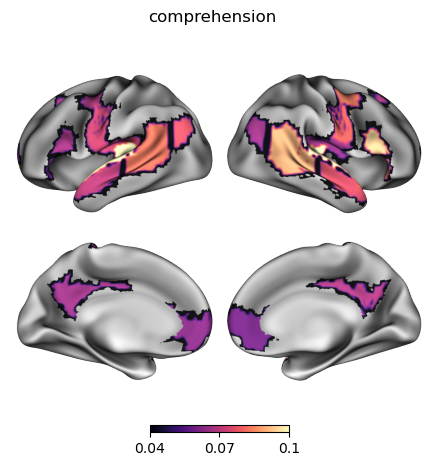

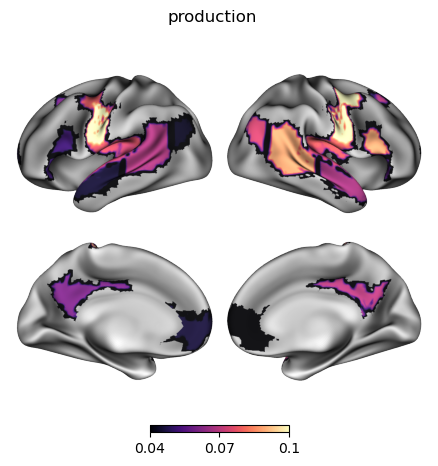

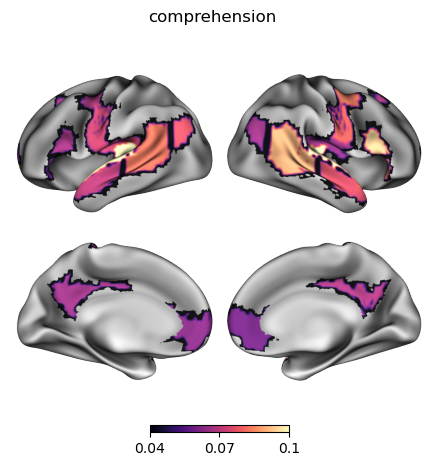

In [122]:
plot_surface_brain(prod_rois, cmap="magma", vmin=0.04, vmax=0.1, title="production")
plot_surface_brain(comp_rois, cmap="magma", vmin=0.04, vmax=0.1, title="comprehension")

## Parcels

In [10]:
surfaces = fetch_fslr(data_dir="mats")
lh, rh = surfaces["inflated"]


def plot_surface_brain(
    data: np.ndarray,
    title: str = "",
    cmap: str = "YlOrRd_r",
    val_threshold=None,
    vmin: Optional[float] = None,
    vmax: Optional[float] = None,
):
    stat_lh, stat_rh = mni152_to_fslr(data)  # type: ignore
    if val_threshold:
        stat_lh = threshold(stat_lh.agg_data(), val_threshold)
        stat_rh = threshold(stat_rh.agg_data(), val_threshold)
    p = Plot(surf_lh=lh, surf_rh=rh)
    sulc_lh, sulc_rh = surfaces["sulc"]
    p.add_layer({"left": sulc_lh, "right": sulc_rh}, cmap="binary_r", cbar=False)

    crange = None
    if vmax is not None:
        crange = (-vmax, vmax)
        if vmin is not None:
            crange = (vmin, vmax)

    p.add_layer(
        {"left": stat_lh, "right": stat_rh}, cmap=cmap, cbar=True, color_range=crange
    )
    fig = p.build()
    fig.suptitle(title)
    return fig

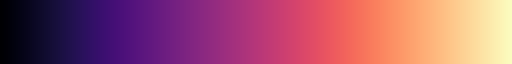

In [18]:
cmap = "icefire"
cmap = "plasma"
cmap = "inferno"
cmap = "magma"
cmap = color_palette(cmap, as_cmap=True)
cmap

In [12]:
all_scores.shape

(3, 1000)

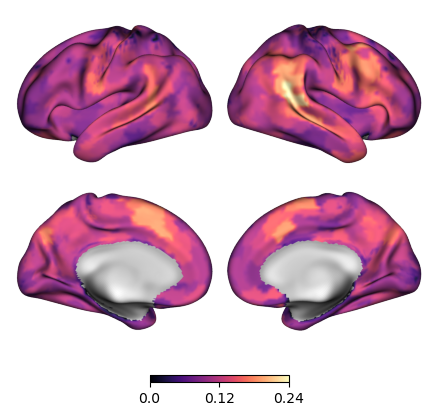

In [20]:
out = masker.inverse_transform(all_scores[1:].sum(0))
# fig = plot_surface_brain(out, cmap=cmap, vmin=0.1, vmax=0.15, val_threshold=0.1)
fig = plot_surface_brain(out, cmap=cmap)
fig.show()

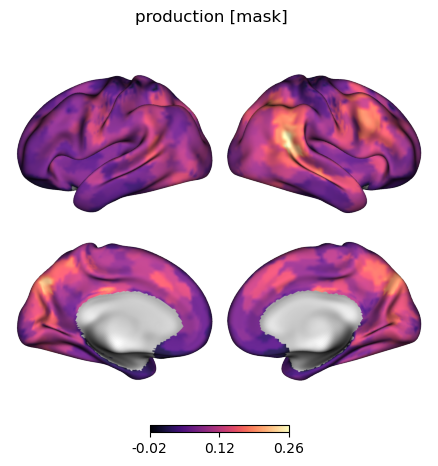

In [22]:
out = masker.inverse_transform(all_prods)
# fig = plot_surface_brain(out, cmap=cmap, vmin=0.1, vmax=0.15, val_threshold=0.1)
fig = plot_surface_brain(out, cmap=cmap, title="production [mask]")
fig.show()

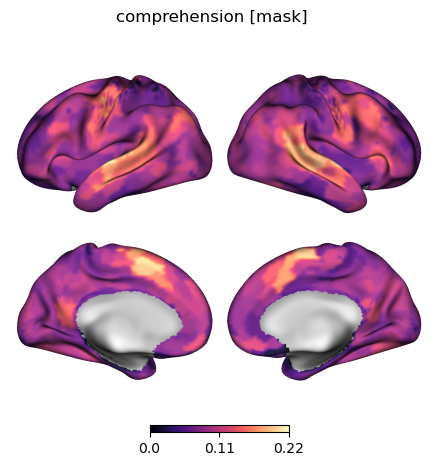

In [23]:
out = masker.inverse_transform(all_comps)
# fig = plot_surface_brain(out, cmap=cmap, vmin=0.1, vmax=0.15, val_threshold=0.1)
fig = plot_surface_brain(out, cmap=cmap, title="comprehension [mask]")
fig.show()

In [102]:
print(all_scores[0].max())
print(all_scores[1:].sum(0).max())

0.3126607330513324
0.15872608755930587


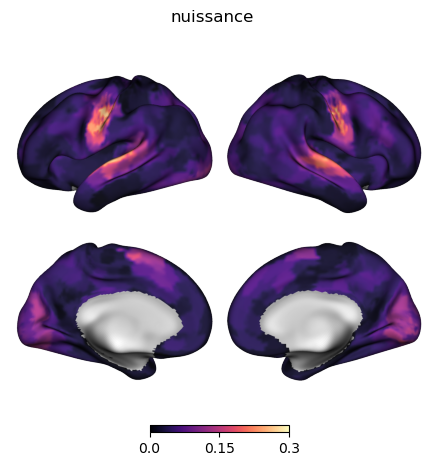

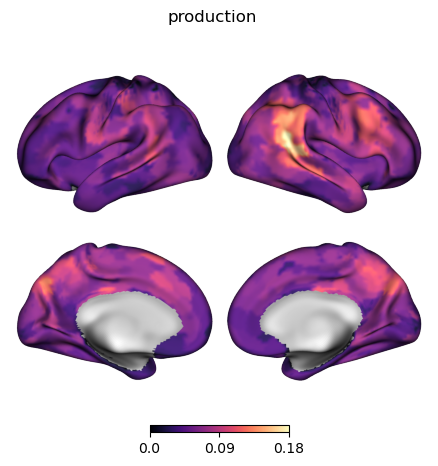

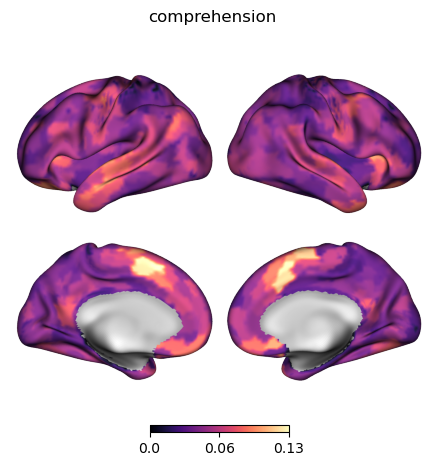

In [24]:
feature_names = ("nuissance", "production", "comprehension")
for i, feature in enumerate(feature_names):
    out = masker.inverse_transform(all_scores[i])
    fig = plot_surface_brain(out, cmap=cmap, title=feature)  # type: ignore
    fig.show()
    # fig.savefig(f'{feature}.svg')

In [45]:
scores[0].shape

(5, 3, 1000)

In [52]:
corrs = np.stack(scores)
corrs = corrs.mean(1)  # folds
corrs.shape

(48, 3, 1000)

In [67]:
mx = corrs[:, 1].max()
mx

0.6711221255695848

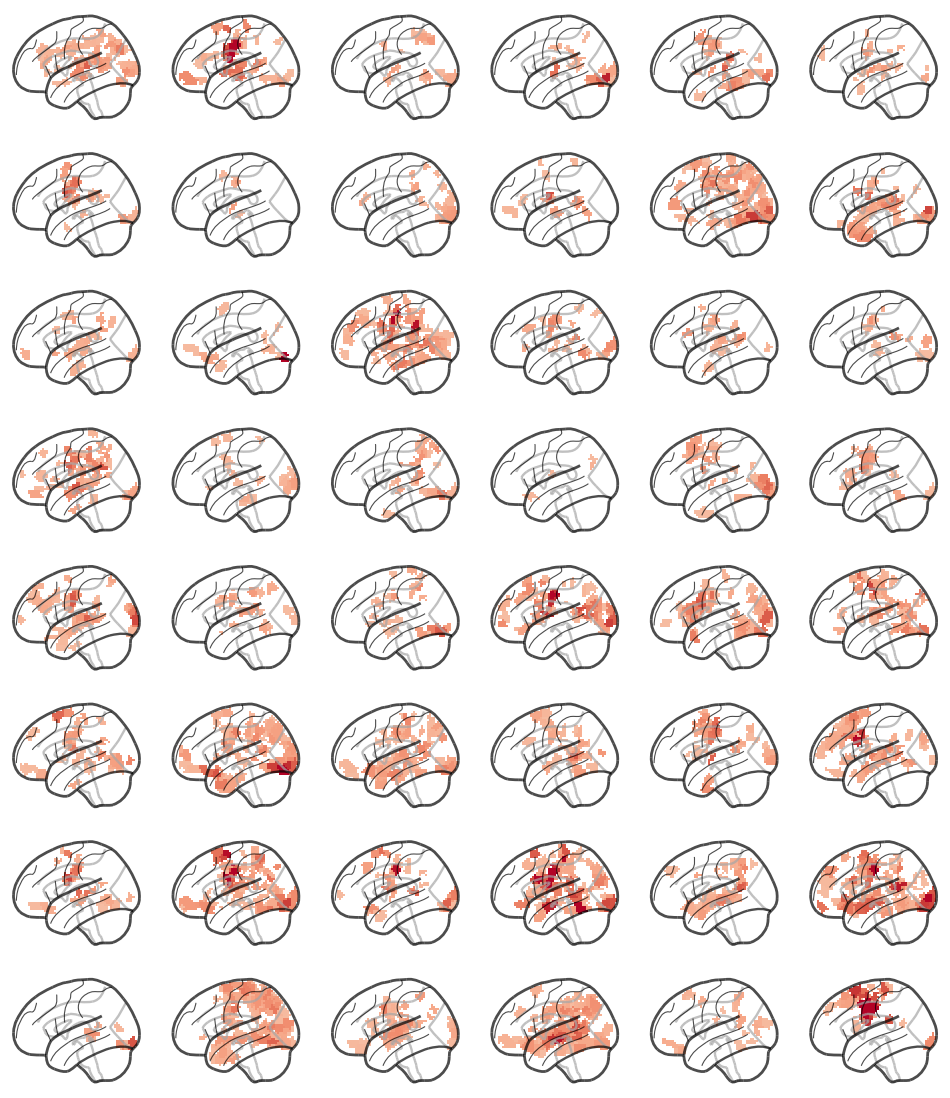

In [68]:
fig, axes = plt.subplots(8, 6, figsize=(12, 14))

for i, ax in enumerate(axes.flatten()):
    subout = masker.inverse_transform(corrs[i][1])
    plot_glass_brain(
        subout,
        cmap="coolwarm",
        vmin=-0.5,
        vmax=0.5,
        display_mode="l",
        figure=fig,
        axes=ax,
        threshold=0.15,
    )
fig.show()

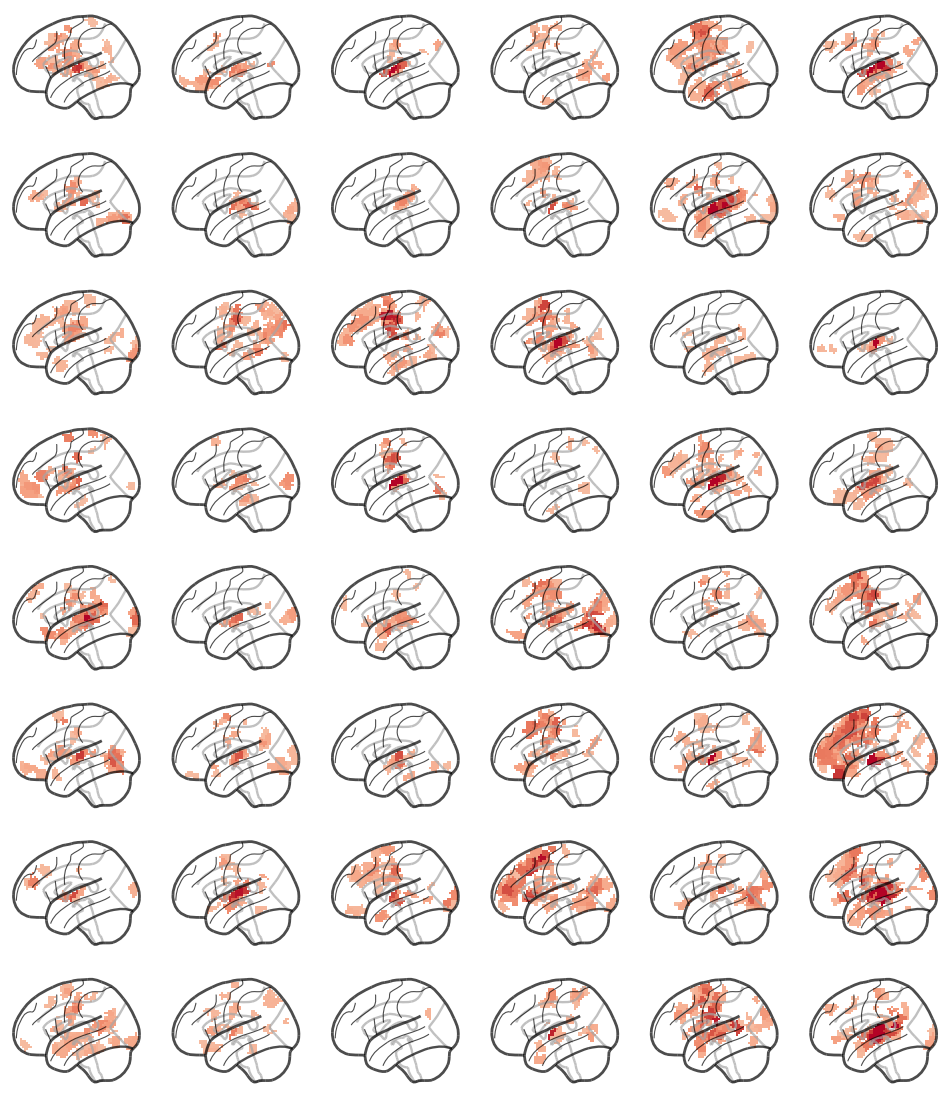

In [66]:
fig, axes = plt.subplots(8, 6, figsize=(12, 14))

for i, ax in enumerate(axes.flatten()):
    subout = masker.inverse_transform(corrs[i][2])
    plot_glass_brain(
        subout,
        cmap="coolwarm",
        vmin=-0.5,
        vmax=0.5,
        display_mode="l",
        figure=fig,
        axes=ax,
        threshold=0.15,
    )
fig.show()